In [1]:
%pip install tensorflow 
import keras
print(keras.__version__)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
3.2.1


In [2]:
%pip install matplotlib
%pip install pandas
%pip install scikit-learn

import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from keras.optimizers import Adam

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl (11.5 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.4.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.13.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.4.0-py3-none-a

In [3]:
def calculate_moving_average(data, window_size=20):
    """
    Calculates the moving average for the specified window size.

    Parameters:
        data (pd.DataFrame): DataFrame with stock data.
        window_size (int): The size of the moving window.

    Returns:
        pd.DataFrame: DataFrame with moving average added as a new column.
    """
    data['Moving_Average'] = data['Close'].rolling(window=window_size).mean()
    return data

In [4]:
def calculate_rsi(data, window_size=14):
    """
    Calculate the Relative Strength Index (RSI) for the given data.

    Parameters:
        data (pd.DataFrame): DataFrame containing the stock prices.
        window_size (int): The period over which to calculate RSI values.

    Returns:
        pd.DataFrame: DataFrame with the RSI added as a new column.
    """
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window_size).mean()
    avg_loss = loss.rolling(window=window_size).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi

    return data


In [118]:
df_stocks = pd.read_csv('sp500_stocks.csv')
#df_stocks = calculate_moving_average(df_stocks, window_size=15)
sc = MinMaxScaler(feature_range = (0, 1))
scaler = sc.fit(df_stocks[["Close", "High", "Low", "Open", "Volume"]])
df_stocks[["Close", "High", "Low", "Open", "Volume"]] = scaler.transform(df_stocks[["Close", "High", "Low", "Open", "Volume"]])
print(df_stocks[["Close", "High", "Low", "Open", "Volume"]].shape)
df_stocks.drop(labels=['Adj Close'], axis='columns', inplace=True)
df_stocks.dropna(inplace=True)
df_stocks.set_index('Symbol', inplace=True)
grouped = df_stocks.groupby(level=0)
df_stocks_dict = {group: group_df for group, group_df in grouped}

(1809291, 5)


# Below sets the data up to predict 1 day in the future

In [119]:
import numpy as np

numdays = 330
windowSize = 25

megaDF = []

for key in df_stocks_dict:
    temp_df = df_stocks_dict[key][(-1 * windowSize):].copy()  # Create a copy of the DataFrame
    temp_df.drop(columns=temp_df.columns[0], axis=1, inplace=True)

    if temp_df.shape[0] == windowSize:  # Check if temp_df has the desired number of rows
        megaDF.append(temp_df.values)  # Append the values to megaDF
    else:
        print(f"Ignoring {key} due to insufficient data for window calculation")
        continue

mega_array = np.array(megaDF)
print(mega_array.shape)

Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 25, 5)


In [120]:
np.random.seed(42)
tf.random.set_seed(42)

layersNodes = [64, 64, 64]

model = keras.models.Sequential([
    keras.layers.LSTM(layersNodes[0], return_sequences=True, input_shape=[None, 5]),
    keras.layers.Dropout(0.10),
    keras.layers.LSTM(layersNodes[1], return_sequences=True),
    keras.layers.Dropout(0.10),
    keras.layers.LSTM(layersNodes[2], return_sequences=False),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(1)
])
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=optimizer)


C:\Users\Sean\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Below is code that utlizes k-folds cross validation**

In [121]:
k = 5  # Number of folds
epochs = 24
kf = KFold(n_splits=k, shuffle=True, random_state=42)
test = True;
    # Perform model training and evaluation using X_train, y_train, X_val, and y_val
for train_index, val_index in kf.split(mega_array):
    X_train, X_val = mega_array[train_index, 1:], mega_array[val_index, 1:]
    y_train, y_val = mega_array[train_index, 0], mega_array[val_index, 0]

    # Train your model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate your model
    loss = model.evaluate(X_val, y_val)
    print("Validation Loss:", loss)

model.save("1day_LSTM_no_MA_model.h5")

Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.8725e-04 - val_loss: 0.0022
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8031e-04 - val_loss: 6.5731e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9662e-04 - val_loss: 8.9330e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3387e-04 - val_loss: 6.7985e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6521e-04 - val_loss: 7.1134e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4946e-04 - val_loss: 6.5591e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4068e-04 - val_loss: 6.5107e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4806e-04 - val_loss: 8.0915e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7043e-04 - val_loss: 9.5882e-04
Epoch 10/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6610e-04 - val_loss: 6.7086e-04
Epoch 11/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8944e-04 - 

Validation Loss: 0.00046367530012503266


# BELOW IS CODE AND MODEL TO PREDICT DAYS INTO THE FUTURE

In [112]:
np.random.seed(42)
tf.random.set_seed(42)

layersNodes = [64, 64, 64]

multi_model = keras.models.Sequential([
    keras.layers.LSTM(layersNodes[0], return_sequences=True, input_shape=[None, 5]),
    keras.layers.Dropout(0.10),
    keras.layers.LSTM(layersNodes[1], return_sequences=True),
    keras.layers.Dropout(0.10),
    keras.layers.LSTM(layersNodes[2], return_sequences=False),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(1)
])
optimizer = Adam(learning_rate=0.001)
multi_model.compile(loss="mse", optimizer=optimizer)


In [99]:
windowSize = 25
prediction_days = 15

multiMegaDF = []

for key in df_stocks_dict:
    temp_df = df_stocks_dict[key][(-1 * (windowSize + prediction_days)):].copy()  # Grab the last windowSize + prediction_days days
    temp_df.drop(columns=temp_df.columns[0], axis=1, inplace=True)

    if temp_df.shape[0] == (windowSize + prediction_days):  # Check if temp_df has the desired number of rows
        multiMegaDF.append(temp_df.values)  # Append the values to multiMegaDF
    else:
        print(f"Ignoring {key} due to insufficient data for window calculation")
        continue

multi_mega_array = np.array(multiMegaDF)
print(multi_mega_array.shape)


(501, 40, 6)


In [100]:

for train_index, val_index in kf.split(multi_mega_array):
    multi_X_train, multi_X_val = multi_mega_array[train_index, :-prediction_days], multi_mega_array[val_index, :-prediction_days]
    multi_y_train, multi_y_val = multi_mega_array[train_index, -1], multi_mega_array[val_index, -1]
    
    print(multi_X_train.shape)
    print(multi_X_val.shape)
    print(multi_y_train.shape)
    print(multi_y_val.shape)

    # Train your model
    multi_history = multi_model.fit(multi_X_train, multi_y_train, epochs=epochs, batch_size=32, validation_data=(multi_X_val, multi_y_val))

    # Evaluate your model
    multi_loss = multi_model.evaluate(multi_X_val, multi_y_val)
    print("Validation Loss:", multi_loss)

multi_model.save("3weeks_gru_no_MA_model.h5")


(400, 25, 6)
(101, 25, 6)
(400, 6)
(101, 6)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6640e-04 - val_loss: 5.8332e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7034e-04 - val_loss: 5.9527e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7162e-04 - val_loss: 5.7597e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7040e-04 - val_loss: 6.1170e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9214e-04 - val_loss: 5.8246e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7361e-04 - val_loss: 6.0340e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8000e-04 - val_loss: 5.9014e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8135e-04 - val_loss: 5.8008e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6887e-04 - val_loss: 6.3448e-04
Epoch 10/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7994e-04 - val_loss: 5.8112e-04
Epoch 11/24
13/13 ━━━━━━━

Validation Loss: 0.00036582385655492544


In [27]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True, title="series"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(windowSize, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(windowSize, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.title(title)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [28]:
def plot_learning_curves(loss, val_loss, title):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)

Evaluation: 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8156e-04 


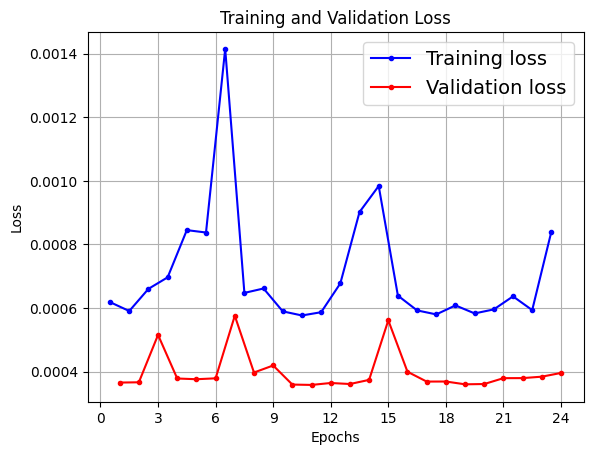

<Figure size 640x480 with 0 Axes>

In [77]:
print("Evaluation: ")
multi_loss = multi_model.evaluate(multi_X_val, multi_y_val)

plot_learning_curves(multi_history.history["loss"], multi_history.history["val_loss"],
                        "Training and Validation Loss")
plt.show()
plt.savefig('loss.png')


file1 = open("parameterTesting.txt", "a")
L = ["windowSize: " + str(windowSize), "   epochs: " + str(epochs),
     "  nodes: " + str(layersNodes[0]) + " " + str(layersNodes[1]) + " " + str(layersNodes[2]),
     "   loss: " + str(loss) + "\n"]
file1.writelines(L)
file1.close()

Evaluation: 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9412e-04  


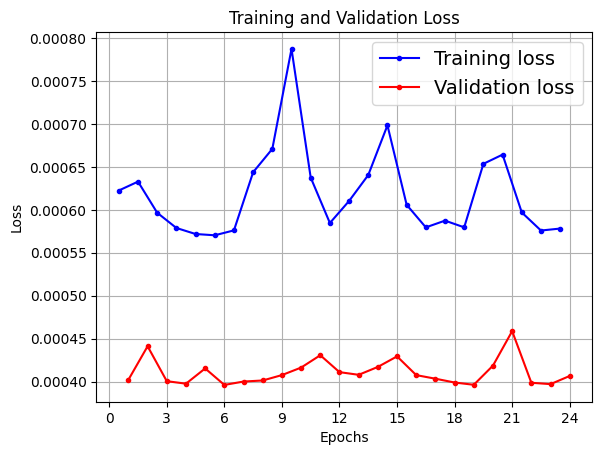

<Figure size 640x480 with 0 Axes>

In [78]:
print("Evaluation: ")
loss = model.evaluate(X_val, y_val)

plot_learning_curves(history.history["loss"], history.history["val_loss"],
                        "Training and Validation Loss")
plt.show()
plt.savefig('loss.png')


file1 = open("parameterTesting.txt", "a")
L = ["windowSize: " + str(windowSize), "   epochs: " + str(epochs),
     "  nodes: " + str(layersNodes[0]) + " " + str(layersNodes[1]) + " " + str(layersNodes[2]),
     "   loss: " + str(loss) + "\n"]
file1.writelines(L)
file1.close()


In [101]:
# Get the stock data for a specific stock
stock_name = "AAPL"  # Replace with the desired stock name
stock_data = df_stocks_dict[stock_name]

# Store the last WindowSize days of stock data
last_days_data = stock_data[-windowSize:].copy()

# Drop the 'Date' column
last_days_data.drop(columns=['Date'], inplace=True)

last_days_data = np.array(last_days_data)
reshaped_arr = last_days_data.reshape(1, windowSize, 6)
print(reshaped_arr.shape)

testPred = multi_model.predict(reshaped_arr)

print(testPred)
testPred = [testPred[0][0], 0,0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)

unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred)
print("AAPL Prediction for 4/18: " + str(unscaledPred[0][0]))

(1, 25, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[0.01881199]]
[[153.06316377   0.70999998   0.64999998   0.69999999   0.
    0.75199999]]
AAPL Prediction for 4/18: 153.06316377163765


In [ ]:
#previous 5 days was 176

In [79]:
# Get the stock data for a specific stock
stock_name = "AAPL"  # Replace with the desired stock name
stock_data = df_stocks_dict[stock_name]

# Store the last WindowSize days of stock data
last_days_data = stock_data[-windowSize:].copy()

# Drop the 'Date' column
last_days_data.drop(columns=['Date'], inplace=True)

last_days_data = np.array(last_days_data)
reshaped_arr = last_days_data.reshape(1, windowSize, 6)
print(reshaped_arr.shape)

testPred = model.predict(reshaped_arr)

print(testPred)
testPred = [testPred[0][0], 0,0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)

unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred)
print("AAPL Prediction for 4/18: " + str(unscaledPred[0][0]))

(1, 25, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[0.02522227]]
[[204.98170496   0.70999998   0.64999998   0.69999999   0.
    0.75199999]]
AAPL Prediction for 4/18: 204.98170496473483


(100, 24, 6)
(24, 6)
[0.00163719 0.00163811 0.00165182 0.00163759 0.011215   0.00177325]
[0.00163719 0.00163811 0.00165182 0.00163759 0.011215   0.00177325]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
[[0.00743826]]
[[1.40200005e+01 1.43400002e+01 1.39650002e+01 1.40600004e+01
  3.47314790e+07 1.39213332e+01]]
[60.94442507  0.70999998  0.64999998  0.69999999  0.          0.75199999]


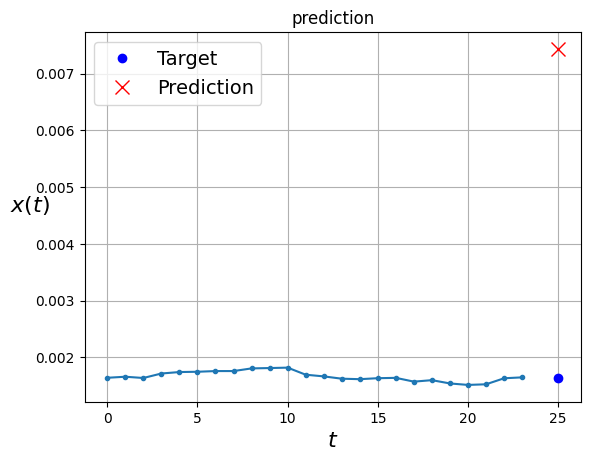

In [80]:
print(X_val.shape)
test = X_val[0]
print(test.shape)
reshaped_arr = test.reshape(1, windowSize -1, 6)

print(reshaped_arr[0][0])
print(test[0])

testPred = model.predict(reshaped_arr)
print(testPred)
testPred = [testPred[0][0], 0,0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)
reshaped_arr = reshaped_arr[0][-1].reshape(1, 6)
print(scaler.inverse_transform(reshaped_arr))
unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred[0])

plot_series(X_val[0, :, 0], y_val[0, 0], testPred[0, 0], title="prediction")

In [20]:
import pickle


# Save the scaler to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [21]:
import pickle

# Load the scaler from the file
with open('scaler.pkl', 'rb') as f:
    scaler2 = pickle.load(f)

In [22]:
# Get the stock data for a specific stock
stock_name = "AAPL"  # Replace with the desired stock name
stock_data = df_stocks_dict[stock_name]

# Store the last WindowSize days of stock data
last_days_data = stock_data[-windowSize:].copy()

# Drop the 'Date' column
last_days_data.drop(columns=['Date'], inplace=True)

last_days_data = np.array(last_days_data)
reshaped_arr = last_days_data.reshape(1, windowSize, 6)
print(reshaped_arr.shape)

testPred = model.predict(reshaped_arr)

print(testPred)
testPred = [testPred[0][0], 0,0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)

unscaledPred = scaler2.inverse_transform(testPred)
print(unscaledPred)
print("AAPL Prediction for 4/18: " + str(unscaledPred[0][0]))

(1, 25, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[0.02458424]]
[[199.81417559   0.70999998   0.64999998   0.69999999   0.
    0.75199999]]
AAPL Prediction for 4/18: 199.81417558805717


In [113]:
#automates the creation of multi-day models
numbers = [2, 3, 4, 5, 10, 15, 20, 25]

for x in numbers:
    windowSize = 25
    temp_prediction_days = x

    multiMegaDF = []

    for key in df_stocks_dict:
        temp_df = df_stocks_dict[key][(-1 * (windowSize + temp_prediction_days)):].copy()  # Grab the last windowSize + prediction_days days
        temp_df.drop(columns=temp_df.columns[0], axis=1, inplace=True)
    
        if temp_df.shape[0] == (windowSize + temp_prediction_days):  # Check if temp_df has the desired number of rows
            multiMegaDF.append(temp_df.values)  # Append the values to multiMegaDF
        else:
            print(f"Ignoring {key} due to insufficient data for window calculation")
            continue
    
    multi_mega_array = np.array(multiMegaDF)
    print(multi_mega_array.shape)


    for train_index, val_index in kf.split(multi_mega_array):
        multi_X_train, multi_X_val = multi_mega_array[train_index, :-temp_prediction_days], multi_mega_array[val_index, :-temp_prediction_days]
        multi_y_train, multi_y_val = multi_mega_array[train_index, -1], multi_mega_array[val_index, -1]
        
        print(multi_X_train.shape)
        print(multi_X_val.shape)
        print(multi_y_train.shape)
        print(multi_y_val.shape)
    
        # Train your model
        multi_history = multi_model.fit(multi_X_train, multi_y_train, epochs=epochs, batch_size=32, validation_data=(multi_X_val, multi_y_val))
    
        # Evaluate your model
        multi_loss = multi_model.evaluate(multi_X_val, multi_y_val)
        print("Validation Loss:", multi_loss)
    
    multi_model.save(str(temp_prediction_days) + "days_lstm_no_MA_model.h5")


Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 27, 5)
(400, 25, 5)
(101, 25, 5)
(400, 5)
(101, 5)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.9460e-04 - val_loss: 6.5269e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8082e-04 - val_loss: 0.0011
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8871e-04 - val_loss: 7.4829e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5363e-04 - val_loss: 9.0095e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1910e-04 - val_loss: 0.0010
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1269e-04 - val_loss: 6.6227e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7908e-04 - val_loss: 8.7429e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8450e-04 - val_loss: 6.8088e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2026e-04 - val_loss: 8.

Validation Loss: 0.0004121232486795634
Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 28, 5)
(400, 25, 5)
(101, 25, 5)
(400, 5)
(101, 5)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1709e-04 - val_loss: 6.4866e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0975e-04 - val_loss: 6.5141e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1991e-04 - val_loss: 6.5567e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2824e-04 - val_loss: 6.4862e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1163e-04 - val_loss: 7.2485e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5198e-04 - val_loss: 6.5081e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5405e-04 - val_loss: 6.6356e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4618e-04 - val_loss: 6.6053e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━━

Validation Loss: 0.0004310031945351511
Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 29, 5)
(400, 25, 5)
(101, 25, 5)
(400, 5)
(101, 5)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5254e-04 - val_loss: 7.4482e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3936e-04 - val_loss: 7.4027e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3553e-04 - val_loss: 7.1380e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7159e-04 - val_loss: 6.5883e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1311e-04 - val_loss: 6.7489e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1486e-04 - val_loss: 6.5333e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1215e-04 - val_loss: 6.5777e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1289e-04 - val_loss: 6.5385e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━━

Validation Loss: 0.00040456117130815983
Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 30, 5)
(400, 25, 5)
(101, 25, 5)
(400, 5)
(101, 5)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1983e-04 - val_loss: 7.0948e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4042e-04 - val_loss: 6.6745e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2484e-04 - val_loss: 6.5253e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1713e-04 - val_loss: 6.5071e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1852e-04 - val_loss: 6.5214e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2644e-04 - val_loss: 6.6911e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1562e-04 - val_loss: 6.5093e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1653e-04 - val_loss: 6.5290e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━

Validation Loss: 0.00043594720773398876
Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 35, 5)
(400, 25, 5)
(101, 25, 5)
(400, 5)
(101, 5)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2094e-04 - val_loss: 6.7034e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2823e-04 - val_loss: 6.6145e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1755e-04 - val_loss: 6.5764e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2775e-04 - val_loss: 6.6303e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2037e-04 - val_loss: 6.5595e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2667e-04 - val_loss: 6.7248e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1759e-04 - val_loss: 6.5110e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0981e-04 - val_loss: 6.6134e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━

Validation Loss: 0.0004052388248965144
Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 40, 5)
(400, 25, 5)
(101, 25, 5)
(400, 5)
(101, 5)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1204e-04 - val_loss: 6.5204e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1445e-04 - val_loss: 6.5519e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2055e-04 - val_loss: 6.7396e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1962e-04 - val_loss: 6.5299e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0843e-04 - val_loss: 6.5003e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1002e-04 - val_loss: 6.5539e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1304e-04 - val_loss: 6.4957e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1548e-04 - val_loss: 6.5302e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━━

Validation Loss: 0.0004038415791001171
Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 45, 5)
(400, 25, 5)
(101, 25, 5)
(400, 5)
(101, 5)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2771e-04 - val_loss: 6.8061e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1908e-04 - val_loss: 6.6233e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1198e-04 - val_loss: 6.5166e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1934e-04 - val_loss: 6.7943e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1251e-04 - val_loss: 6.6817e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1346e-04 - val_loss: 6.6197e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0896e-04 - val_loss: 6.6830e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1408e-04 - val_loss: 6.5325e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━━

Validation Loss: 0.00040482019539922476
Ignoring GEV due to insufficient data for window calculation
Ignoring SOLV due to insufficient data for window calculation
(501, 50, 5)
(400, 25, 5)
(101, 25, 5)
(400, 5)
(101, 5)
Epoch 1/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1192e-04 - val_loss: 6.8863e-04
Epoch 2/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1845e-04 - val_loss: 6.7070e-04
Epoch 3/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1132e-04 - val_loss: 6.5672e-04
Epoch 4/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2201e-04 - val_loss: 6.6078e-04
Epoch 5/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1705e-04 - val_loss: 6.7669e-04
Epoch 6/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1818e-04 - val_loss: 6.5988e-04
Epoch 7/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1030e-04 - val_loss: 6.6196e-04
Epoch 8/24
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1259e-04 - val_loss: 6.5802e-04
Epoch 9/24
13/13 ━━━━━━━━━━━━━━━━━━━

Validation Loss: 0.00040706805884838104
